In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
df_train = pd.read_csv('train.csv')
print(df_train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Data Preprocessing and Feature Selection

Примерный план:
1. Сначала займеся тем, что более детально взглянем на данные, для того чтобы понять, какие переменные оказывают наибольшее влияние на целевую переменную, а от каких можно избавиться.
2. Тем или иным образом избавиться от пропусков в данных.
3. Избавиться от очевидных выбросов в данных.


In [4]:
print(df_train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


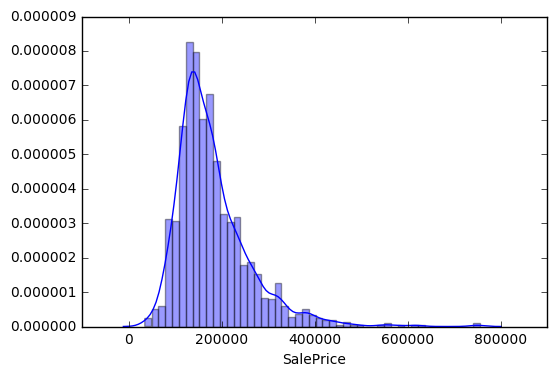

In [5]:
sns.distplot(df_train['SalePrice'])

## Correlations

Построим матрицу корреляции для того чтобы обнаружить переменные, которые сильно скоррелированы и имеют наибольшую корреляцию с ```SalePrice```.

Из визуализации, например, видно, что ```TotalBsmtSF``` имеет большую корреляцию с ```1stFlrSF```, так же как и переменные ```GarageCars```, ```GarageArea```, что выглядит вполне осмысленно.

Так же мы можем видеть, что с переменной ```SalePrice``` сильно коррелируют ```OverallQual```, ```GrLiveArea```, ```GarageCars```, ```GarageArea```.

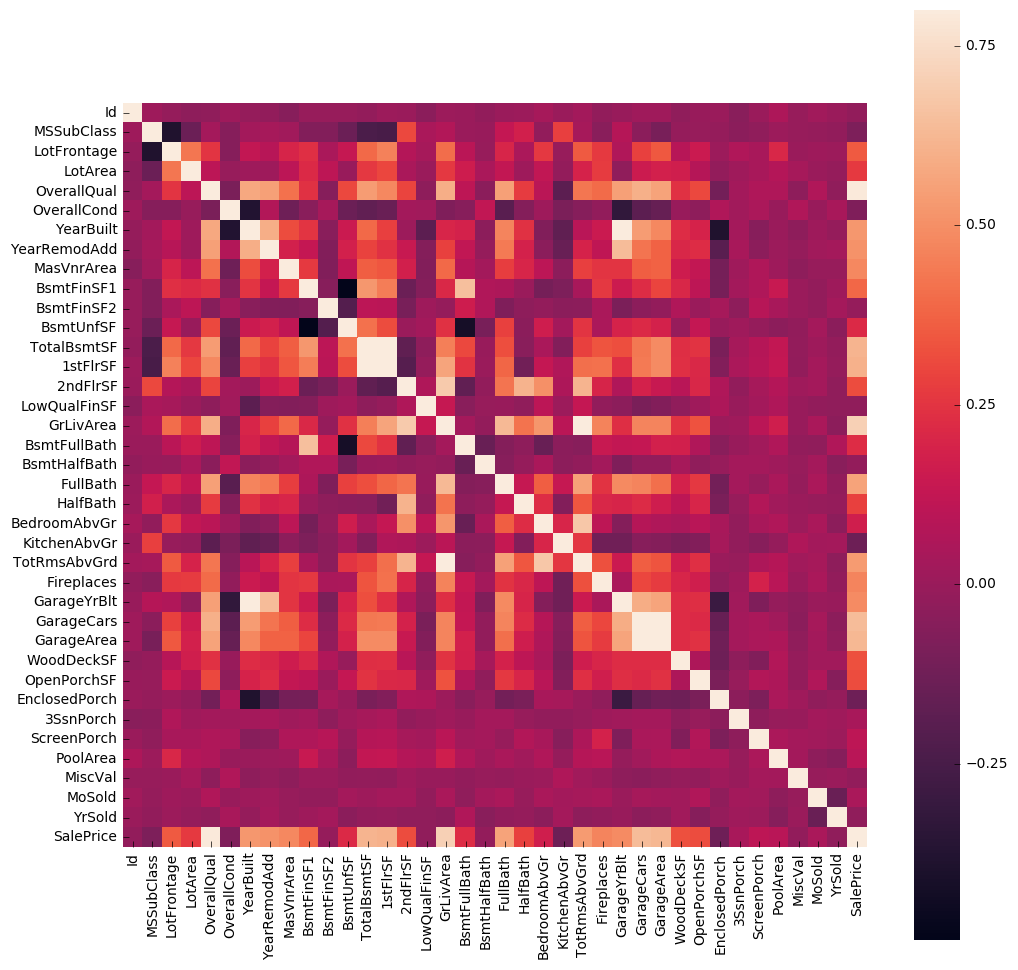

In [6]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

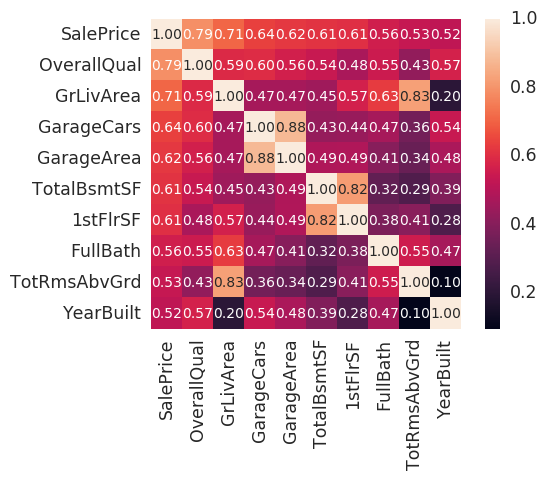

In [7]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Из визуализации видно, что некоторые переменные являются в некотором смысле близнецами: GarageCars and GarageArea. Оставим только GarageCars, так как данная переменная имеет большую корреляцию с SalePrice.

Похожие выводы можно сформулировать и о других парах переменных.

Посмотрим теперь на то, какой характер имеет закономерность между выбранными переменными.

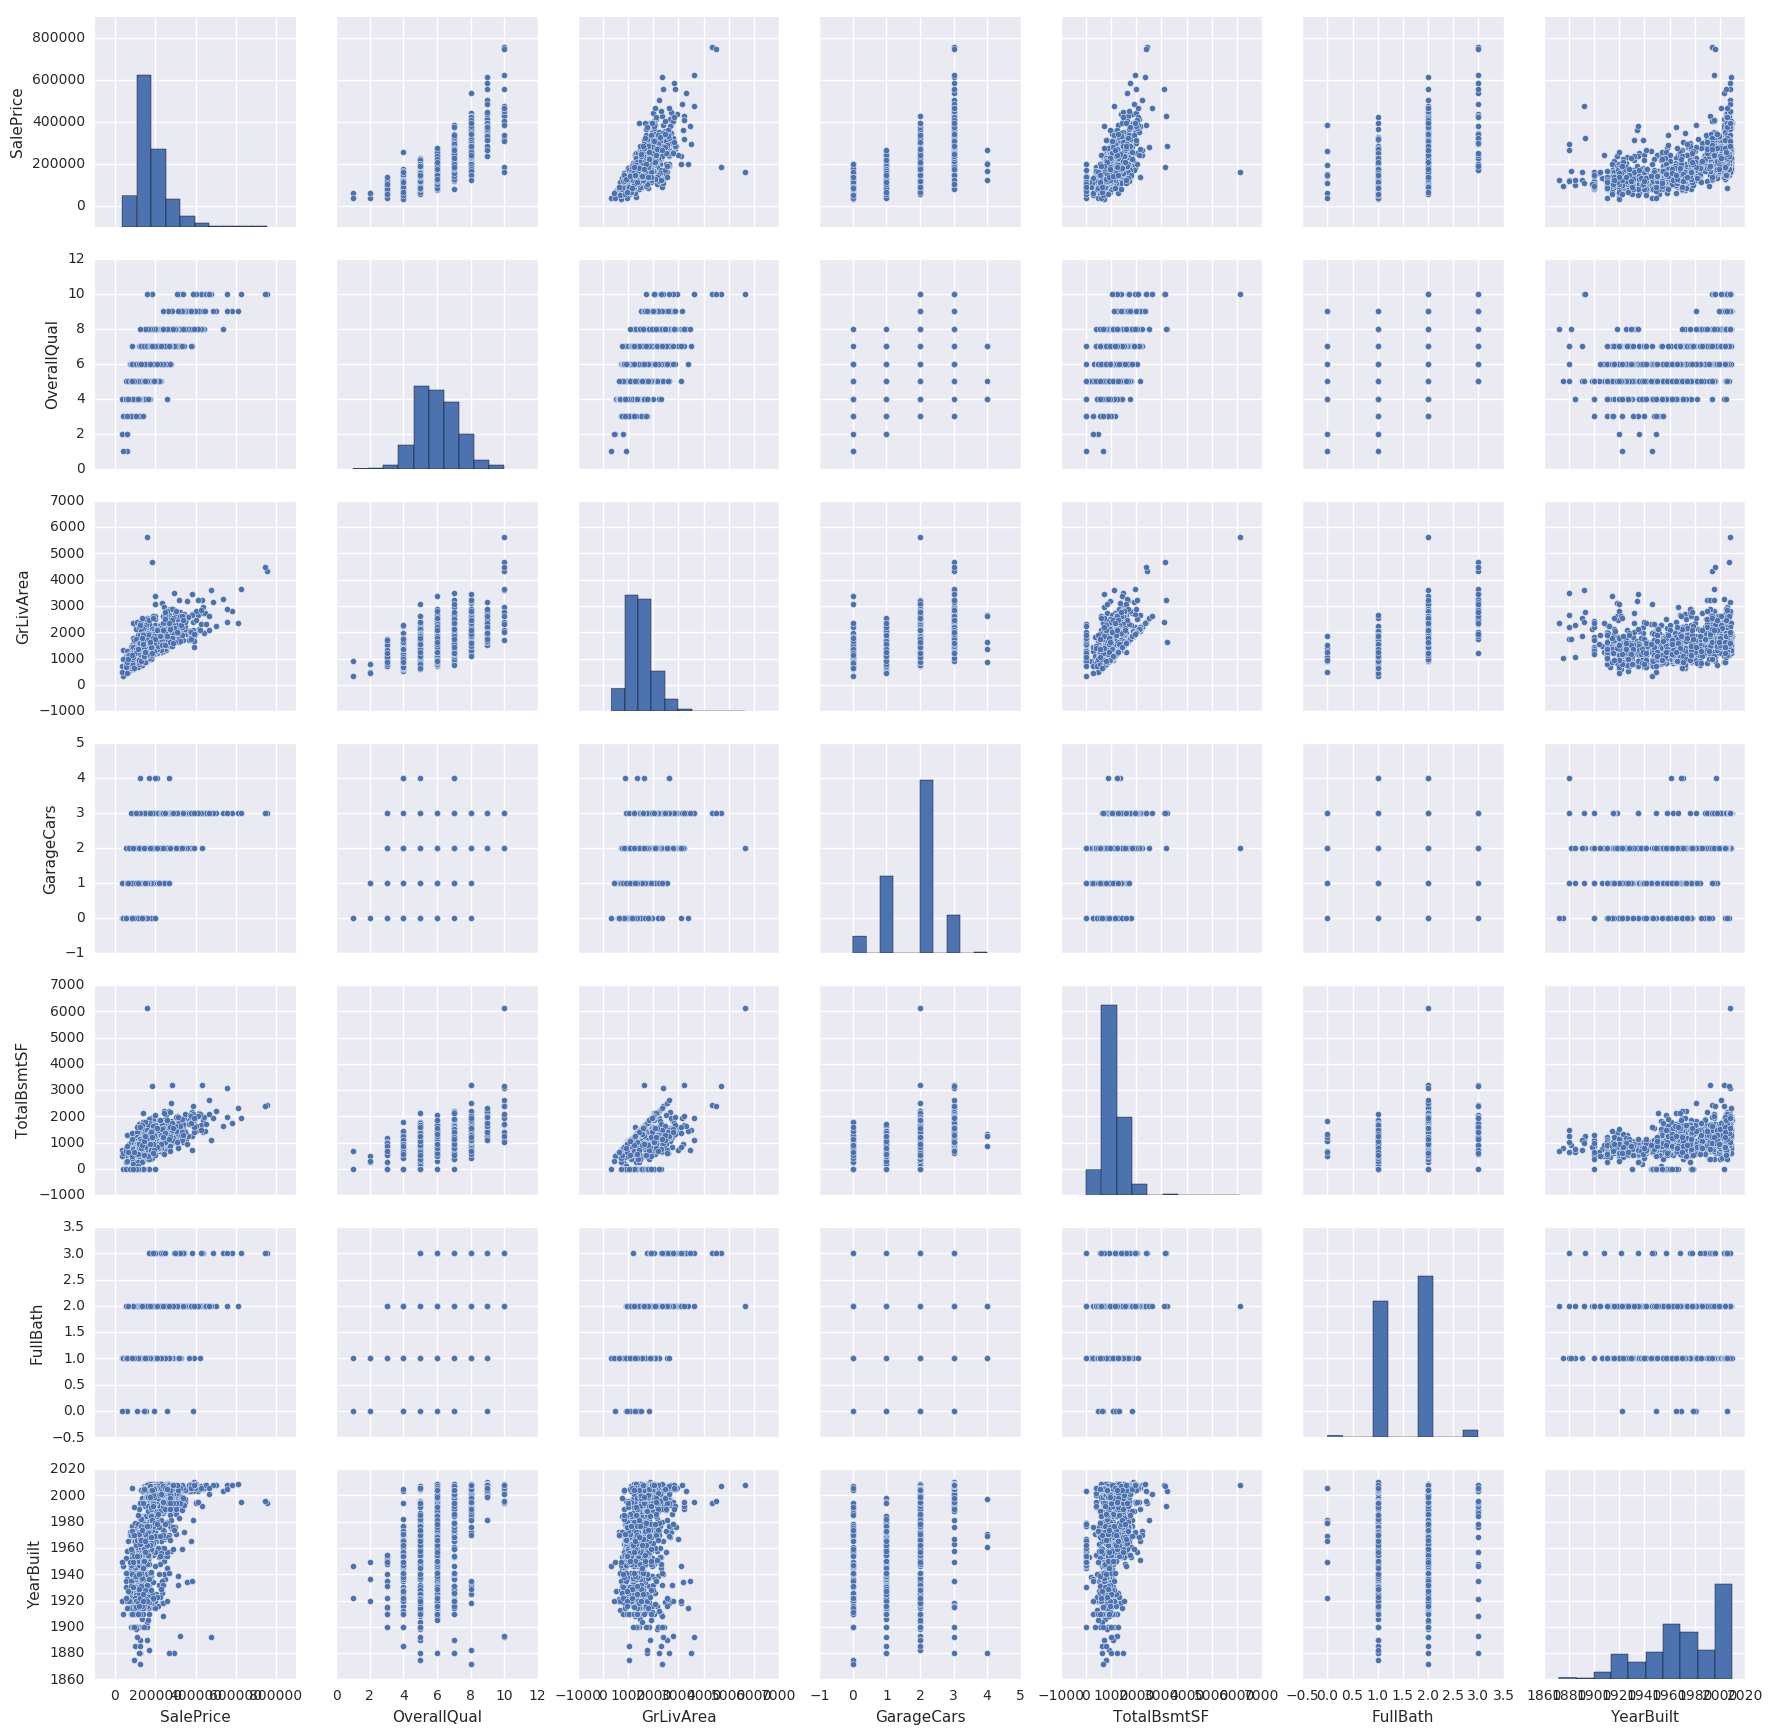

In [8]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

Смотря на некоторые из scatter-plot'ов (например, SalePrice vs. GrLiveArea) можно сформулировать предположение о наличии выбросов в данных.

В целом можно сказать, что наблюдаемые зависимости (SalePrice vs. ...) имеют линейный характер, поэтому нет явной необходимости в выполнении нелинейных преобразований переменных.

## Missing Data

Решим теперь проблему связанную с пропусками в данных.

Исходя из правила, что если в данных есть более 15% пропусков о рассматриваемой переменной можно забыть, мы можем избавиться от переменных PoolQC (pool quality), MiscFeature, Alley (type of alley access), Fence (fence quality), FireplaceQu, LotFrontage. Так же можно заметить, что рассматриваемые переменные редко имеют значение при покупке дома.

Так же мы можем избавиться от переменных GarageX, так как не смотря на небольшое количество пропусков (~5%), данные переменные имеют слабую корреляцию с SalePrice.

В общем, немного подумав и посмотрев на матрицу корреляции, можно избавиться от всех переменных, в которых есть пропуски.

In [9]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [10]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [11]:
selected_features = df_train.columns
selected_features = selected_features.drop('SalePrice')
print(selected_features)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')


## Outliers

Прежде чем использовать более мощные техники на подобие LOF или IsolationForest, мы можем избавиться от выбросов просто посмотрев на scatter-plot'ы.

In [12]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [13]:
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

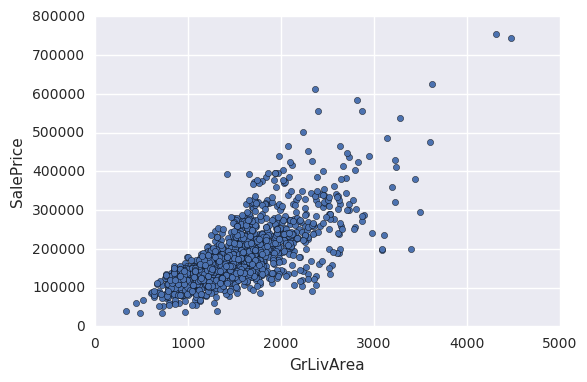

In [14]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

# Regression Models

Прежде чем перейти к построению моделей, сделаем train_test_split данных из ```df_train```.

In [15]:
df_train.drop('Id', axis=1, inplace=True)

In [16]:
y = df_train['SalePrice']
df_train.drop('SalePrice', axis=1, inplace=True)

In [17]:
df_test = pd.read_csv('test.csv')
df_test.isnull().sum().max()

1456

In [18]:
df_test = df_test[selected_features]
ids = df_test['Id']
df_test.drop('Id', axis=1, inplace=True)

df_test.isnull().sum().max()

4

In [19]:
all_data = pd.concat([df_train, df_test])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [20]:
all_data.isnull().sum().max()

0

In [21]:
from sklearn.model_selection import train_test_split


X = all_data[:df_train.shape[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
X_validate = all_data[df_train.shape[0]:]

In [48]:
def make_submission(preds):
    result = pd.concat([ids, pd.DataFrame(preds ,columns=['SalePrice'])], axis=1)
    result.to_csv('submission.csv', index=False)

## Model 1

Попробуем простую линейную регрессию.

In [79]:
from sklearn import linear_model


def model1(params, X=X_train, y=y_train):
    lin_reg = linear_model.LinearRegression(**params)
    lin_reg.fit(X, y)
    
    return lin_reg

In [80]:
reg = model1({})

In [82]:
from sklearn.metrics import mean_squared_error


def score(y_true, y_pred, take_log=True):
    if take_log:
        return np.sqrt(mean_squared_error(np.log(y_true), np.log(np.abs(y_pred))))
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [84]:
score(y_test, reg.predict(X_test))

0.18548716864698053

In [85]:
reg.score(X_test, y_test)

0.87176734730793926

In [27]:
make_submission(reg.pred(X_validate))

Попробуем модели с регуляризаторами

In [86]:
reg = linear_model.Ridge(alpha=1.0)
reg.fit(X_train, y_train)
print(reg.score(X_test, y_test))
score(y_test, reg.predict(X_test))

0.892795689967


0.15359455930475258

In [29]:
def plot_residuals(reg):
    preds = pd.DataFrame({"preds":reg.predict(X_train), "true":y_train})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter")

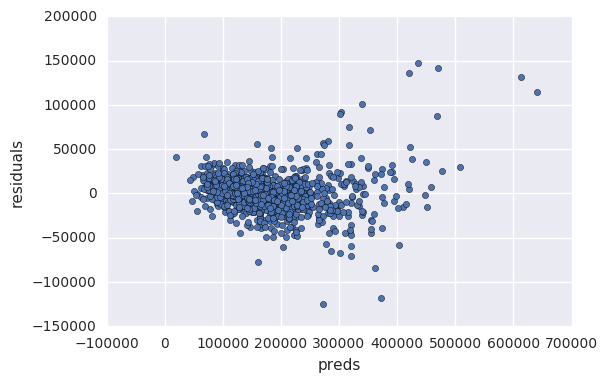

In [30]:
plot_residuals(reg)

In [31]:
make_submission(reg.pred(X_validate))

Попробуем выполнить некоторые преобразования в самих данных, для того чтобы выполнялись предположения, которые часто выдвигаются для линейной регрессии.

In [172]:
from sklearn.model_selection import GridSearchCV


def rmse_log(estimator, X, y):
    return -score(y, estimator.predict(X))

def GS(reg, p_grid, X=X_train, y=y_train, tl=True):
    gsearch = GridSearchCV(estimator=reg, 
                           param_grid=p_grid, 
                           scoring=lambda estimator, X, y: -score(y, estimator.predict(X), tl), 
                           n_jobs=1,  
                           cv=3, 
                           error_score=0)

    gsearch.fit(X, y)

    return gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

In [90]:
param_grid1 = {
    'alpha':[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
}
    
gs, bp, bs = GS(linear_model.Ridge(), param_grid1)
print(gs, bp, bs)

[mean: -0.16166, std: 0.02128, params: {'alpha': 0.05}, mean: -0.16029, std: 0.02099, params: {'alpha': 0.1}, mean: -0.15790, std: 0.02147, params: {'alpha': 0.3}, mean: -0.16232, std: 0.03232, params: {'alpha': 1}, mean: -0.16208, std: 0.03469, params: {'alpha': 3}, mean: -0.15524, std: 0.02541, params: {'alpha': 5}, mean: -0.15205, std: 0.01970, params: {'alpha': 10}, mean: -0.15190, std: 0.01793, params: {'alpha': 15}, mean: -0.15385, std: 0.01636, params: {'alpha': 30}, mean: -0.15679, std: 0.01576, params: {'alpha': 50}, mean: -0.15990, std: 0.01533, params: {'alpha': 75}] {'alpha': 15} -0.151904334886


In [95]:
reg = linear_model.Ridge(alpha=10.0).fit(X_train, y_train)

print(reg.score(X_test, y_test))
score(y_test, reg.predict(X_test))

0.899879493595


0.1451848339378331

In [96]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [195]:
rreg = linear_model.Ridge(alpha=4.0).fit(X_train, y_train_log)
print(rreg.score(X_test, y_test_log))
score(y_test_log, rreg.predict(X_test), take_log=False)

0.915038983908


0.12141605650429838

In [103]:
make_submission(np.exp(rreg.predict(X_validate)))

Попробуем избавиться от выбросов в данных

In [147]:
from sklearn.ensemble import IsolationForest


clf = IsolationForest()
clf.fit(X_train)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [148]:
y_pred = clf.predict(X_train)
print(len(y_pred), len([_ for label in y_pred if label == -1]))

1165 117


In [155]:
X_inliers = X_train[y_pred==1]
y_inliers = y_train_log[y_pred==1]

In [194]:
rreg = linear_model.Ridge(alpha=13.0).fit(X_inliers, y_inliers)
print(rreg.score(X_test, y_test_log))
score(y_test_log, rreg.predict(X_test), take_log=False)

0.914202331859


0.12201241314458258

## Model 2

In [107]:
from sklearn.ensemble import RandomForestRegressor


reg = RandomForestRegressor().fit(X_train, y_train_log)
print(reg.score(X_test, y_test_log))
score(y_test_log, reg.predict(X_test), take_log=False)

0.860083721182


0.15581181892371318

In [173]:
param_grid1 = {
    'n_estimators':range(10, 200, 20)
}
    
gs, bp, bs = GS(RandomForestRegressor(), param_grid1, y=y_train_log, tl=False)
print(gs, bp, bs)

[mean: -0.15079, std: 0.00886, params: {'n_estimators': 10}, mean: -0.14158, std: 0.01089, params: {'n_estimators': 30}, mean: -0.14121, std: 0.00964, params: {'n_estimators': 50}, mean: -0.14118, std: 0.00984, params: {'n_estimators': 70}, mean: -0.13997, std: 0.01029, params: {'n_estimators': 90}, mean: -0.14007, std: 0.01145, params: {'n_estimators': 110}, mean: -0.13867, std: 0.01030, params: {'n_estimators': 130}, mean: -0.13922, std: 0.01069, params: {'n_estimators': 150}, mean: -0.13858, std: 0.01079, params: {'n_estimators': 170}, mean: -0.14010, std: 0.01035, params: {'n_estimators': 190}] {'n_estimators': 170} -0.138575987139


In [174]:
reg = RandomForestRegressor(n_estimators=170).fit(X_train, y_train_log)
print(reg.score(X_test, y_test_log))
score(y_test_log, reg.predict(X_test), take_log=False)

0.883923959897


0.1419180274928229

## Model 3

In [169]:
import xgboost as xgb


reg = xgb.XGBRegressor().fit(X_inliers, y_inliers)
print(reg.score(X_test, y_test_log))
score(y_test_log, reg.predict(X_test), take_log=False)

0.90844061898


0.12604270017813071

In [176]:
param_grid1 = {
    'n_estimators':range(100,300,50)
}
    
gs, bp, bs = GS(xgb.XGBRegressor(), param_grid1, X=X_inliers, y=y_inliers, tl=False)
print(gs, bp, bs)

[mean: -0.12434, std: 0.01103, params: {'n_estimators': 100}, mean: -0.12236, std: 0.01053, params: {'n_estimators': 150}, mean: -0.12140, std: 0.01024, params: {'n_estimators': 200}, mean: -0.12085, std: 0.01002, params: {'n_estimators': 250}] {'n_estimators': 250} -0.120854504091


In [182]:
reg = xgb.XGBRegressor(n_estimators=200).fit(X_inliers, y_inliers)
print(reg.score(X_test, y_test_log))
score(y_test_log, reg.predict(X_test), take_log=False)

0.911593650367


0.12385342007943322

In [183]:
param_grid2 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gs, bp, bs = GS(xgb.XGBRegressor(n_estimators=200), param_grid2, X=X_inliers, y=y_inliers, tl=False)
print(gs, bp, bs)

[mean: -0.12140, std: 0.01024, params: {'min_child_weight': 1, 'max_depth': 3}, mean: -0.11959, std: 0.00968, params: {'min_child_weight': 3, 'max_depth': 3}, mean: -0.12213, std: 0.01026, params: {'min_child_weight': 5, 'max_depth': 3}, mean: -0.12594, std: 0.00984, params: {'min_child_weight': 1, 'max_depth': 5}, mean: -0.12436, std: 0.01230, params: {'min_child_weight': 3, 'max_depth': 5}, mean: -0.12428, std: 0.01191, params: {'min_child_weight': 5, 'max_depth': 5}, mean: -0.12783, std: 0.00914, params: {'min_child_weight': 1, 'max_depth': 7}, mean: -0.12764, std: 0.01095, params: {'min_child_weight': 3, 'max_depth': 7}, mean: -0.12563, std: 0.01179, params: {'min_child_weight': 5, 'max_depth': 7}, mean: -0.12900, std: 0.00924, params: {'min_child_weight': 1, 'max_depth': 9}, mean: -0.12739, std: 0.01030, params: {'min_child_weight': 3, 'max_depth': 9}, mean: -0.12767, std: 0.01078, params: {'min_child_weight': 5, 'max_depth': 9}] {'min_child_weight': 3, 'max_depth': 3} -0.11958875

In [208]:
reg = xgb.XGBRegressor(n_estimators=200).fit(X_inliers, y_inliers)
print(reg.score(X_test, y_test_log))
score(y_test_log, reg.predict(X_test), take_log=False)

0.911593650367


0.12385342007943322

In [215]:
score(y_test_log, 0.60 * rreg.predict(X_test) + 0.40 * reg.predict(X_test), take_log=False)

0.11695569934736647

In [216]:
make_submission(np.exp(0.60 * rreg.predict(X_validate) + 0.40 * reg.predict(X_validate)))